In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv


# Import required libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import f1_score,mean_squared_error

# Import train and test dataset

In [3]:
data = pd.read_csv("/kaggle/input/titanic/train.csv")
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")
data.shape

(891, 12)

In [4]:
data.nunique().sort_values(ascending=False).head(5)

Name           891
PassengerId    891
Ticket         681
Fare           248
Cabin          147
dtype: int64

## Droping features which have many categories

In [5]:
data.drop(["Name","Ticket","Cabin"],axis=1,inplace=True)
data.head(),data.shape

(   PassengerId  Survived  Pclass     Sex   Age  SibSp  Parch     Fare Embarked
 0            1         0       3    male  22.0      1      0   7.2500        S
 1            2         1       1  female  38.0      1      0  71.2833        C
 2            3         1       3  female  26.0      0      0   7.9250        S
 3            4         1       1  female  35.0      1      0  53.1000        S
 4            5         0       3    male  35.0      0      0   8.0500        S,
 (891, 9))

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Sex          891 non-null    object 
 4   Age          714 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Fare         891 non-null    float64
 8   Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(2)
memory usage: 62.8+ KB


# Handling Missing Values

In [7]:
data.isnull().sum().sort_values(ascending = False).head()

Age         177
Embarked      2
Fare          0
Parch         0
SibSp         0
dtype: int64

In [8]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')

#Fill  those NAN values with mean of the feature column
data.Age = imp.fit_transform(data[['Age']]).ravel()

imp2 = SimpleImputer(missing_values=np.nan,strategy='most_frequent')
data.Embarked = imp2.fit_transform(data[['Embarked']]).ravel()

data.Age.mean(),data.Age.std(),data.Age.isnull().sum()

(29.699117647058763, 13.002015226002884, 0)

In [9]:
data.isnull().sum().sort_values(ascending = False).head(2)

Embarked    0
Fare        0
dtype: int64

## EDA

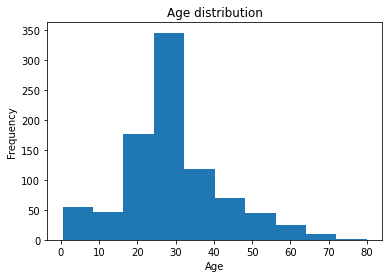

In [10]:
plt.hist(data.Age,bins=10)
plt.title("Age distribution")
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.show()

In [11]:
table = pd.crosstab(data['Survived'],data['Sex']);table

Sex,female,male
Survived,,
0,81,468
1,233,109


In [12]:
data.groupby('Sex').Survived.mean() #Females were the greater amount of surviours

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

In [13]:
#Which Class had greater survival rate
table = pd.crosstab(data['Survived'],data['Pclass'])
table

Pclass,1,2,3
Survived,,,
0,80,97,372
1,136,87,119


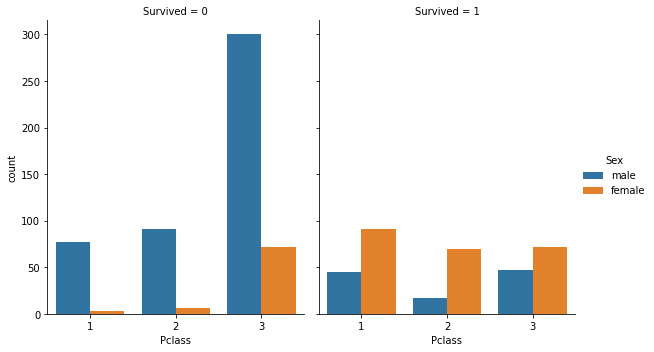

In [14]:
##SEX and Pclass
sns.catplot(x='Pclass',hue='Sex',col='Survived',data = data,kind = 'count',height=5,aspect=.8)
plt.show()

# Main Model

In [15]:
data.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,male,22.0,1,0,7.2500,S
1,2,1,1,female,38.0,1,0,71.2833,C
2,3,1,3,female,26.0,0,0,7.9250,S
3,4,1,1,female,35.0,1,0,53.1000,S
4,5,0,3,male,35.0,0,0,8.0500,S


### SibSp and Parch tells numbers of siblings/spouses and parents/children aboard the Titanic respectively
- So we will create a new feature column which will contain the infomation whether the person was alone or not

In [16]:
data['relatives'] = data['SibSp'] + data['Parch']
data.loc[data['relatives'] > 0, 'not_alone'] = 0
data.loc[data['relatives'] == 0, 'not_alone'] = 1
data['not_alone'] = data['not_alone'].astype(int)

In [17]:
data.tail(2)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,relatives,not_alone
889,890,1,1,male,26.0,0,0,30.00,C,0,1
890,891,0,3,male,32.0,0,0,7.75,Q,0,1


## Handling Categorical values
- Sex and Embraked are categorical features

In [18]:
data = data.join(pd.get_dummies(data['Sex']))
data = data.join(pd.get_dummies(data['Embarked']))
data.tail()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,relatives,not_alone,female,male,C,Q,S
886,887,0,2,male,27.000000,0,0,13.00,S,0,1,0,1,0,0,1
887,888,1,1,female,19.000000,0,0,30.00,S,0,1,1,0,0,0,1
888,889,0,3,female,29.699118,1,2,23.45,S,3,0,1,0,0,0,1
889,890,1,1,male,26.000000,0,0,30.00,C,0,1,0,1,1,0,0
890,891,0,3,male,32.000000,0,0,7.75,Q,0,1,0,1,0,1,0


### Do All the preprocessing to test dataset also(This should be done side to side with train data

In [19]:
test_data.drop(["Name","Ticket","Cabin"],axis=1,inplace=True)

test_data['relatives'] = test_data['SibSp'] + test_data['Parch']
test_data.loc[test_data['relatives'] > 0, 'not_alone'] = 0
test_data.loc[test_data['relatives'] == 0, 'not_alone'] = 1
test_data['not_alone'] = test_data['not_alone'].astype(int)

test_data.Age = imp.transform(test_data[['Age']]).ravel()
test_data.Embarked = imp2.transform(test_data[['Embarked']]).ravel()

test_data = test_data.join(pd.get_dummies(test_data['Sex']))
test_data = test_data.join(pd.get_dummies(test_data['Embarked']))

test_data.shape

(418, 15)

### Select the features so that model be trained to


In [20]:
"""Don't select dummy varibles to get trap"""

f = ['Pclass','Age','SibSp','Parch','Fare','relatives','not_alone','female','C','Q']

len(f)

10

In [21]:
test_data.Fare.fillna(method = 'ffill',inplace=True)

In [22]:
X = data[f]
X_test = test_data[f]

y = data['Survived']

In [23]:
X.shape,X_test.shape

((891, 10), (418, 10))

# Stacking of Models
- Using Scikit inbuilt library

In [24]:
level0 = list()
level0.append(('lr', make_pipeline(StandardScaler(),LogisticRegression())))
level0.append(('cart', DecisionTreeClassifier()))
level0.append(('svm', make_pipeline(StandardScaler(),SVC())))
level0.append(('random_forest', RandomForestClassifier()))

In [25]:
level1 = LogisticRegression()

In [26]:
model = StackingClassifier(estimators=level0, final_estimator=level1)

In [27]:
model.fit(X,y)

StackingClassifier(cv=None,
                   estimators=[('lr',
                                Pipeline(memory=None,
                                         steps=[('standardscaler',
                                                 StandardScaler(copy=True,
                                                                with_mean=True,
                                                                with_std=True)),
                                                ('logisticregression',
                                                 LogisticRegression(C=1.0,
                                                                    class_weight=None,
                                                                    dual=False,
                                                                    fit_intercept=True,
                                                                    intercept_scaling=1,
                                                                    l1_ratio=None,
    

## Submitting the result

In [28]:
pred_y = model.predict(X_test)

In [29]:
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': pred_y})
output.to_csv('my_submission.csv', index=False)
print("Submitted successfully!")

Submitted successfully!


* # This Model can be futher improved by using Hyperparamter turing
* # Some better EDA can be done.
* # Some more robust algorithms can be used